In [1]:
!curl -L https://www.dropbox.com/s/qsdq7sx946t39pa/amazon.tar?dl=1 -o amazon.tar

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  637M  100  637M    0     0  38.2M      0  0:00:16  0:00:16 --:--:-- 43.9M


In [2]:
!tar xvf amazon.tar

Streaming output truncated to the last 5000 lines.
amazon/train-jpg/train_19718.jpg
amazon/train-jpg/train_38480.jpg
amazon/train-jpg/train_16787.jpg
amazon/train-jpg/train_621.jpg
amazon/train-jpg/train_28212.jpg
amazon/train-jpg/train_29928.jpg
amazon/train-jpg/train_30979.jpg
amazon/train-jpg/train_12790.jpg
amazon/train-jpg/train_37996.jpg
amazon/train-jpg/train_4564.jpg
amazon/train-jpg/train_423.jpg
amazon/train-jpg/train_15263.jpg
amazon/train-jpg/train_28557.jpg
amazon/train-jpg/train_17206.jpg
amazon/train-jpg/train_28792.jpg
amazon/train-jpg/train_12157.jpg
amazon/train-jpg/train_3899.jpg
amazon/train-jpg/train_34358.jpg
amazon/train-jpg/train_9458.jpg
amazon/train-jpg/train_15756.jpg
amazon/train-jpg/train_6353.jpg
amazon/train-jpg/train_2794.jpg
amazon/train-jpg/train_34451.jpg
amazon/train-jpg/train_11776.jpg
amazon/train-jpg/train_26449.jpg
amazon/train-jpg/train_15881.jpg
amazon/train-jpg/train_21669.jpg
amazon/train-jpg/train_31322.jpg
amazon/train-jpg/train_3449.jpg
am

In [0]:
import pandas as pd
import numpy as np
np.random.seed(0)

import cv2

from tqdm.notebook import tqdm
import os

from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import fbeta_score
from tensorflow.keras.optimizers import Adam

from matplotlib import pyplot as plt

import gc

In [65]:
df_train = pd.read_csv('amazon/train_v2.csv')
df_train.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [0]:
img = cv2.imread('amazon/train-jpg/{}.jpg'.format('train_1'))

In [67]:
img.shape

(256, 256, 3)

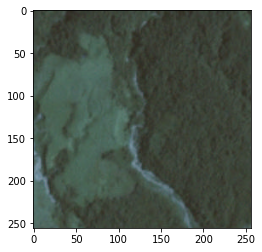

In [68]:
plt.imshow(img)
plt.show()

In [69]:
all_labels = df_train['tags'].map(lambda x: x.split(' ')).values
labels = list(set([y for x in all_labels for y in x]))

print( len(labels), labels )

17 ['artisinal_mine', 'bare_ground', 'primary', 'habitation', 'slash_burn', 'partly_cloudy', 'blooming', 'conventional_mine', 'cultivation', 'selective_logging', 'agriculture', 'blow_down', 'water', 'cloudy', 'clear', 'road', 'haze']


In [0]:
def read_data(df_train, labels, resize=(32, 32)):
    train_split = 5000
    test_split = 1000

    df_train = df_train[:train_split+test_split]
    X_train = []
    y_train = []

    label_map = {l: i for i, l in enumerate(labels)}
    inv_label_map = {i: l for l, i in label_map.items()}



    for f, tags in tqdm(df_train.values, miniters=1000):
        if False == os.path.exists('amazon/train-jpg/{}.jpg'.format(f)): continue

        img = cv2.imread('amazon/train-jpg/{}.jpg'.format(f))
        targets = np.zeros(len(label_map))
        for t in tags.split(' '):
            targets[label_map[t]] = 1 

        X_train.append(cv2.resize(img, resize))
        y_train.append(targets)
        
    y_train = np.array(y_train, np.uint8)
    X_train = np.array(X_train, np.float16) / 255.
    
    # split = 5000#35000

    
    # X_train, X_test, y_train, y_test
    return X_train[:train_split], X_train[train_split:train_split+test_split], y_train[:train_split], y_train[train_split:train_split+test_split]

def fbeta_score_K(y_true, y_pred):
    beta_squared = 4

    tp = K.sum(y_true * y_pred) + K.epsilon()
    fp = K.sum(y_pred) - tp
    fn = K.sum(y_true) - tp

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    result = (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon())

    return result

def learning_curve(model_fit, key='acc', ylim=(0.7, 1.01)):
    plt.figure(figsize=(12,6))
    plt.plot(model_fit.history[key])
    plt.plot(model_fit.history['val_' + key])
    plt.title('Learning Curve')
    plt.ylabel(key.title())
    plt.xlabel('Epoch')
    plt.ylim(ylim)
    plt.legend(['train', 'test'], loc='best')
    plt.show()

In [71]:
if 'X_train' in locals(): del X_train
if 'X_test' in locals(): del X_test
if 'y_train' in locals(): del y_train
if 'y_test' in locals(): del y_test

X_train, X_test, y_train, y_test = read_data(df_train, labels, resize=(128, 128))

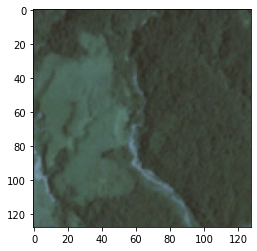

In [72]:
plt.imshow((X_train[1] * 255).astype(int))
plt.show()

In [73]:
X_train.shape

(5000, 128, 128, 3)

## Custom CNN

In [74]:
model = Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3])),
        Conv2D(32, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),

        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(64, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),

        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(128, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),

        Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(256, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),

        Flatten(), 

        Dense(1024, activation='relu'),        
        Dense(512, activation='relu'),
        Dense(17, activation='sigmoid') 
        ])


model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[fbeta_score_K])
model.summary()

Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 126, 126, 32)      9248      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 63, 63, 64)        18496     
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 61, 61, 64)        36928     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 30, 30, 128)     

Epoch 1/30
40/40 [==============================] - 10s 240ms/step - loss: 0.2984 - fbeta_score_K: 0.5272 - val_loss: 0.2712 - val_fbeta_score_K: 0.5424
Epoch 2/30
40/40 [==============================] - 9s 236ms/step - loss: 0.2543 - fbeta_score_K: 0.5642 - val_loss: 0.2417 - val_fbeta_score_K: 0.5838
Epoch 3/30
40/40 [==============================] - 9s 236ms/step - loss: 0.2358 - fbeta_score_K: 0.5796 - val_loss: 0.2248 - val_fbeta_score_K: 0.5986
Epoch 4/30
40/40 [==============================] - 9s 236ms/step - loss: 0.2234 - fbeta_score_K: 0.6032 - val_loss: 0.2627 - val_fbeta_score_K: 0.6199
Epoch 5/30
40/40 [==============================] - 9s 236ms/step - loss: 0.2182 - fbeta_score_K: 0.6137 - val_loss: 0.2069 - val_fbeta_score_K: 0.6207
Epoch 6/30
40/40 [==============================] - 9s 236ms/step - loss: 0.2077 - fbeta_score_K: 0.6359 - val_loss: 0.2136 - val_fbeta_score_K: 0.6640
Epoch 7/30
40/40 [==============================] - 9s 236ms/step - loss: 0.1947 - fbet

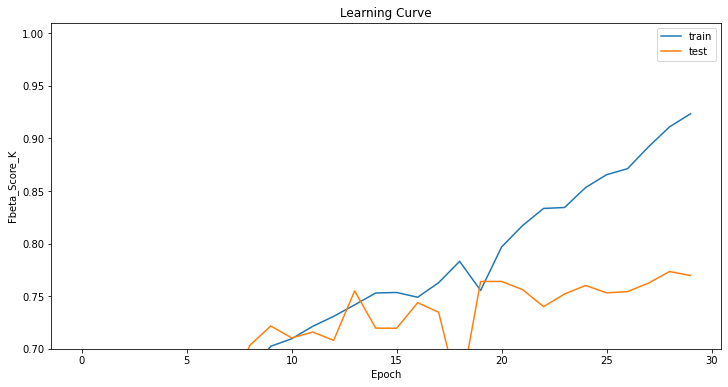

In [75]:
history = model.fit(X_train, y_train,
          batch_size=128,
          epochs=30,
          verbose=1,
          validation_data=(X_test, y_test))

learning_curve(history, 'fbeta_score_K')

## VGG

In [78]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

for layer in base_model.layers:
    layer.trainable = False
    
    model = Sequential([
    base_model,
 
    Flatten(), 
        
    Dense(1024, activation='relu'),
    Dropout(0.2),
    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(17, activation='sigmoid')  
])
    
optimizer = Adam(0.0003, decay=0.000005)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[fbeta_score_K])
model.summary()

Model: "sequential_80"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_80 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dense_221 (Dense)            (None, 1024)              8389632   
_________________________________________________________________
dropout_131 (Dropout)        (None, 1024)              0         
_________________________________________________________________
dense_222 (Dense)            (None, 512)               524800    
_________________________________________________________________
dropout_132 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_223 (Dense)            (None, 17)              

Epoch 1/150
40/40 [==============================] - 11s 283ms/step - loss: 0.2678 - fbeta_score_K: 0.5862 - val_loss: 0.1975 - val_fbeta_score_K: 0.6405 - lr: 3.0000e-04
Epoch 2/150
40/40 [==============================] - 11s 280ms/step - loss: 0.1966 - fbeta_score_K: 0.6612 - val_loss: 0.1753 - val_fbeta_score_K: 0.7030 - lr: 3.0000e-04
Epoch 3/150
40/40 [==============================] - 11s 280ms/step - loss: 0.1785 - fbeta_score_K: 0.6894 - val_loss: 0.1692 - val_fbeta_score_K: 0.7070 - lr: 3.0000e-04
Epoch 4/150
40/40 [==============================] - 11s 281ms/step - loss: 0.1667 - fbeta_score_K: 0.7113 - val_loss: 0.1638 - val_fbeta_score_K: 0.6987 - lr: 3.0000e-04
Epoch 5/150
40/40 [==============================] - 11s 282ms/step - loss: 0.1575 - fbeta_score_K: 0.7244 - val_loss: 0.1586 - val_fbeta_score_K: 0.7445 - lr: 3.0000e-04
Epoch 6/150
40/40 [==============================] - 11s 282ms/step - loss: 0.1510 - fbeta_score_K: 0.7359 - val_loss: 0.1527 - val_fbeta_score_K

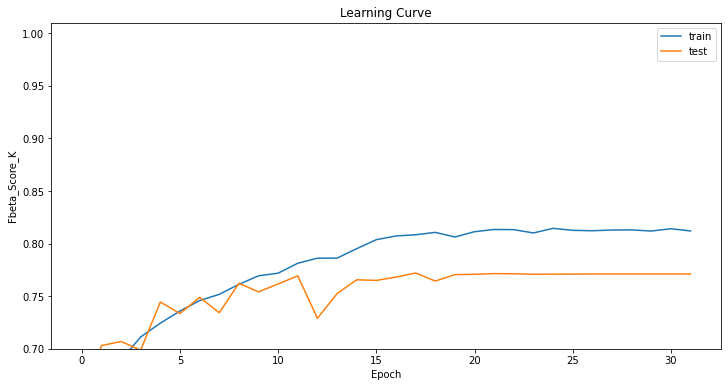

In [79]:
callbacks = [ 
    EarlyStopping(patience=10), #jeśli 4 epoki z rzędu nie ma poprawy, to zatrzymaj się
    ReduceLROnPlateau(patience=3), #jeśli 3 epoki z rzędu nie ma poprawy, zmniejsz krok (learning_rate)
]

history = model.fit(X_train, y_train,
          batch_size=128,
          epochs=150,
          verbose=1,
          validation_data=(X_test, y_test),
          callbacks = callbacks)

learning_curve(history, 'fbeta_score_K')